# Import necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tqdm import tqdm
import cv2
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import Callback
import time

In [2]:
class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (100, 100)

def load_data():
    datasets = ['train']
    output = []

    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print(f"Loading {dataset}")
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            count = 0
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
                # Taking 2k images from of each type because of MemoryError
                count = count + 1
                if count == 2000:
                    break
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [3]:
(images, labels) = load_data()[0]

Loading train


 62%|██████▏   | 1999/3205 [00:11<00:06, 172.80it/s]


In [4]:
permutation  = np.random.permutation(len(images))

shuffled_images = images[permutation]
shuffled_labels = labels[permutation]

In [5]:
train_images, test_images, train_labels, test_labels = train_test_split(shuffled_images, shuffled_labels, test_size=0.1, shuffle=True)
train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((11192, 100, 100, 3), (11192,), (1244, 100, 100, 3), (1244,))

In [6]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

In [7]:
train_labels = to_categorical(train_labels, num_classes=7)
test_labels = to_categorical(test_labels, num_classes=7)

In [8]:
# Custom callback to track epoch times
class TimeHistory(Callback):
    def on_train_begin(self, logs=None):
        self.times = []

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs=None):
        self.times.append(time.time() - self.epoch_time_start)

In [9]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.1
)

In [10]:
# Create data generators
train_generator = datagen.flow_from_directory(
    'train',
    target_size=(100, 100),
    batch_size=64,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    'train',
    target_size=(100, 100),
    batch_size=64,
    class_mode='categorical',
    subset='validation'
)

Found 25942 images belonging to 7 classes.
Found 2879 images belonging to 7 classes.


In [11]:
# Define the CNN model
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(100, 100, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dense(7, activation='softmax')

])


# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

c:\Users\Coltc\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 98, 98, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 47, 47, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 21, 21, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    13,107,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,485,959 (51.44 MB)

 Trainable params: 13,484,039 (51.44 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [12]:
# Train the model
time_callback = TimeHistory()
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[time_callback]
)

Epoch 1/20


c:\Users\Coltc\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


406/406 ━━━━━━━━━━━━━━━━━━━━ 607s 1s/step - accuracy: 0.3286 - loss: 1.9847 - val_accuracy: 0.3029 - val_loss: 1.8253
Epoch 2/20
406/406 ━━━━━━━━━━━━━━━━━━━━ 457s 1s/step - accuracy: 0.4496 - loss: 1.4442 - val_accuracy: 0.3501 - val_loss: 1.6984
Epoch 3/20
406/406 ━━━━━━━━━━━━━━━━━━━━ 570s 1s/step - accuracy: 0.4993 - loss: 1.3250 - val_accuracy: 0.4137 - val_loss: 1.5135
Epoch 4/20
406/406 ━━━━━━━━━━━━━━━━━━━━ 459s 1s/step - accuracy: 0.5333 - loss: 1.2338 - val_accuracy: 0.4859 - val_loss: 1.3980
Epoch 5/20
406/406 ━━━━━━━━━━━━━━━━━━━━ 458s 1s/step - accuracy: 0.5623 - loss: 1.1626 - val_accuracy: 0.4946 - val_loss: 1.3490
Epoch 6/20
406/406 ━━━━━━━━━━━━━━━━━━━━ 455s 1s/step - accuracy: 0.5822 - loss: 1.1012 - val_accuracy: 0.4748 - val_loss: 1.4007
Epoch 7/20
406/406 ━━━━━━━━━━━━━━━━━━━━ 1668s 4s/step - accuracy: 0.6089 - loss: 1.0353 - val_accuracy: 0.4665 - val_loss: 1.5217
Epoch 8/20
406/406 ━━━━━━━━━━━━━━━━━━━━ 548s 1s/step - accuracy: 0.6415 - loss: 0.9804 - val_accuracy: 0.54

In [13]:
# Model Evaluation
loss, accuracy = model.evaluate(validation_generator)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


45/45 ━━━━━━━━━━━━━━━━━━━━ 13s 277ms/step - accuracy: 0.5426 - loss: 1.6479
Test Accuracy: 56.23%


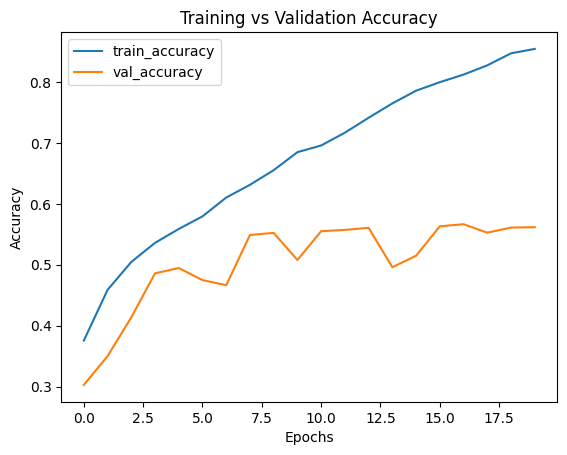

In [14]:
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [15]:
# Print epoch times
print(f"Epoch times: {time_callback.times}")

Epoch times: [607.2245693206787, 457.3389024734497, 569.9887771606445, 459.47654724121094, 458.3381197452545, 454.6842555999756, 1667.858067035675, 547.5820832252502, 606.293265581131, 588.5767455101013, 636.890976190567, 641.2986493110657, 641.549560546875, 567.4738869667053, 530.4344203472137, 544.803382396698, 519.2099874019623, 533.4500255584717, 541.7091271877289, 541.4601120948792]


39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step


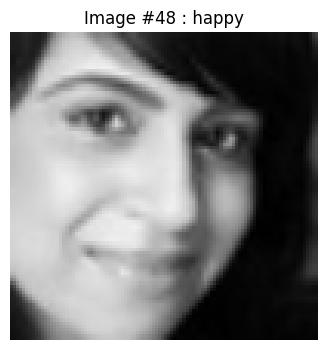

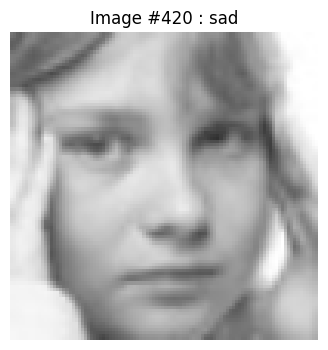

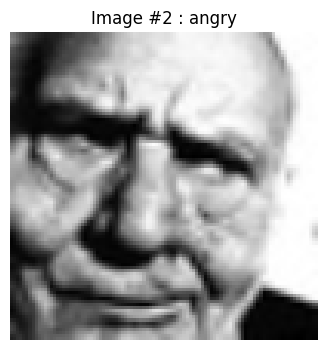

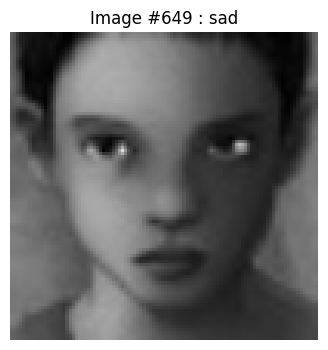

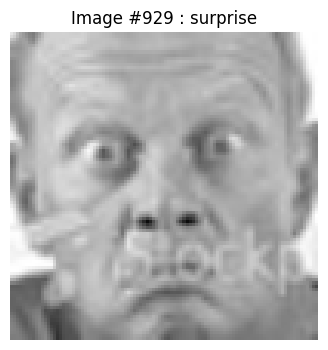

In [16]:
# Make predictions on test images
predictions = model.predict(test_images)
pred_labels = np.argmax(predictions, axis=1)

# Function to display random image and its prediction
def display_random_image(class_names, images, labels):
    index = np.random.randint(len(images))
    label_index = labels[index]

    plt.figure(figsize=(4, 4))
    plt.imshow(images[index])
    plt.title(f'Image #{index} : {class_names[label_index]}')
    plt.axis('off')
    plt.show()

# Display a few random predictions
for _ in range(5):
    display_random_image(class_names, test_images, pred_labels)